In [2]:
# Imports
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.inspection import PartialDependenceDisplay
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.stats import ttest_rel, wilcoxon, pearsonr, spearmanr, ks_2samp

In [3]:
def df_gen(RESULTS_DIR, NSHARDS = 10):  
  dfs = []
  for shard_idx in range(NSHARDS):
    filename = 'results.ndjson-%s-of-%s' % (str(shard_idx).zfill(5), str(NSHARDS).zfill(5))
    print(filename)

    with open(f'{RESULTS_DIR}/{filename}', 'r') as f:
      lines = f.readlines()
      records = map(json.loads, lines)
      dfs.append(pd.DataFrame.from_records(records))

  # Construct df and remove nans
  results_df = pd.concat(dfs)
  results_df.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
  # results_df.dropna(axis=0, inplace=True)
  del dfs
  return results_df

In [4]:
def plot_model_perf_vs_feature_noise_dim(dfs, models, metric, noise_feature_dims):
    plot_data = []
    for i, df in enumerate(dfs):
        # Select the metric columns for the models
        df_copy = df[[f'{model}__{metric}' for model in models]].copy()
        # Add the feature dimension column
        df_copy['feature_dim'] = noise_feature_dims[i]
        plot_data.append(df_copy)

    combined_df_wide = pd.concat(plot_data, ignore_index=True)


    # --- 3. Reshape Data from Wide to Long Format ---
    # This is the key step. We use `pd.melt` to turn the model columns
    # into rows, making the data suitable for seaborn's `hue` parameter.

    id_vars = ['feature_dim']
    value_vars = [f'{model}__{metric}' for model in models]

    combined_df_long = pd.melt(
        combined_df_wide,
        id_vars=id_vars,
        value_vars=value_vars,
        var_name='model_metric', # New column for the original column names
        value_name='performance_score' # New column for the performance values
    )

    # Clean up the model names (e.g., 'GCN__test_rocauc_ovr' -> 'GCN')
    combined_df_long['model'] = combined_df_long['model_metric'].str.replace(f'__{metric}', '', regex=False)


    # --- 4. Create the Combined Boxplot ---
    # Now we create a single plot, using `hue` to differentiate the models.

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))

    sns.boxplot(
        x='feature_dim',
        y='performance_score',
        hue='model', # This tells seaborn to use different colors for each model
        data=combined_df_long,
        ax=ax,
        palette='muted' # A nice color palette
    )

    # --- 5. Customize and Show the Plot ---
    ax.set_title(f'Model Performance ({metric}) vs. Noise Feature Dimension', fontsize=16, fontweight='bold')
    ax.set_xlabel('Number of Noise Features', fontsize=12)
    ax.set_ylabel('Performance Score (ROC AUC)', fontsize=12)
    ax.legend(title='Model') # Add a legend to identify the colors

    plt.tight_layout()
    plt.show()

In [5]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/1'
df = df_gen(RESULTS_DIR = RESULTS_DIR) 

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


In [6]:
plot_model_perf_vs_feature_noise_dim([df], models = ['MLP', 'HGCN', 'GCN'], metric = 'test_rocauc_ovr', noise_feature_dims=[0])

KeyError: "['HGCN__test_rocauc_ovr', 'GCN__test_rocauc_ovr'] not in index"

In [ ]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/'
df75 = df_gen(RESULTS_DIR + '/0.75var')
df5 = df_gen(RESULTS_DIR + '/0.5var')
df2 = df_gen(RESULTS_DIR + '/0.2var')

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


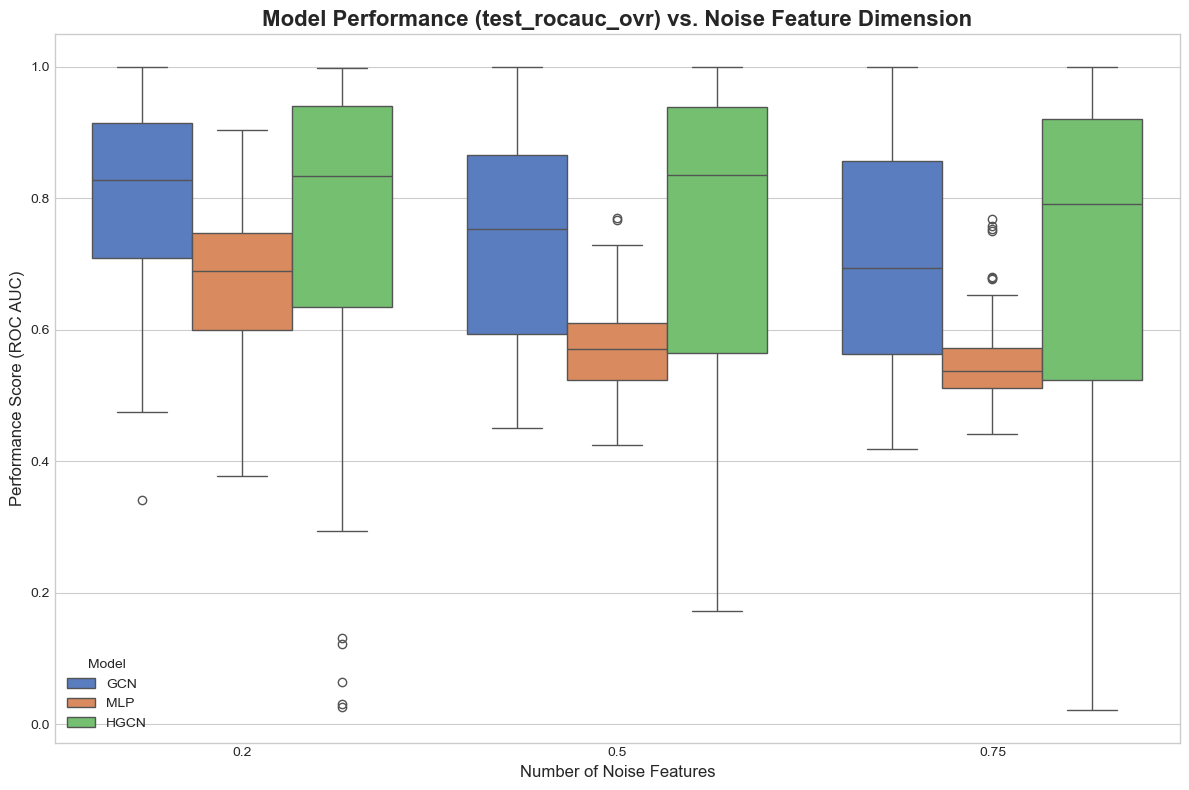

In [ ]:
plot_model_perf_vs_feature_noise_dim(dfs = [df75, df5, df2], metric=metric, models = models, noise_feature_dims = [.75, .5, .2])

## Visualizing ablations

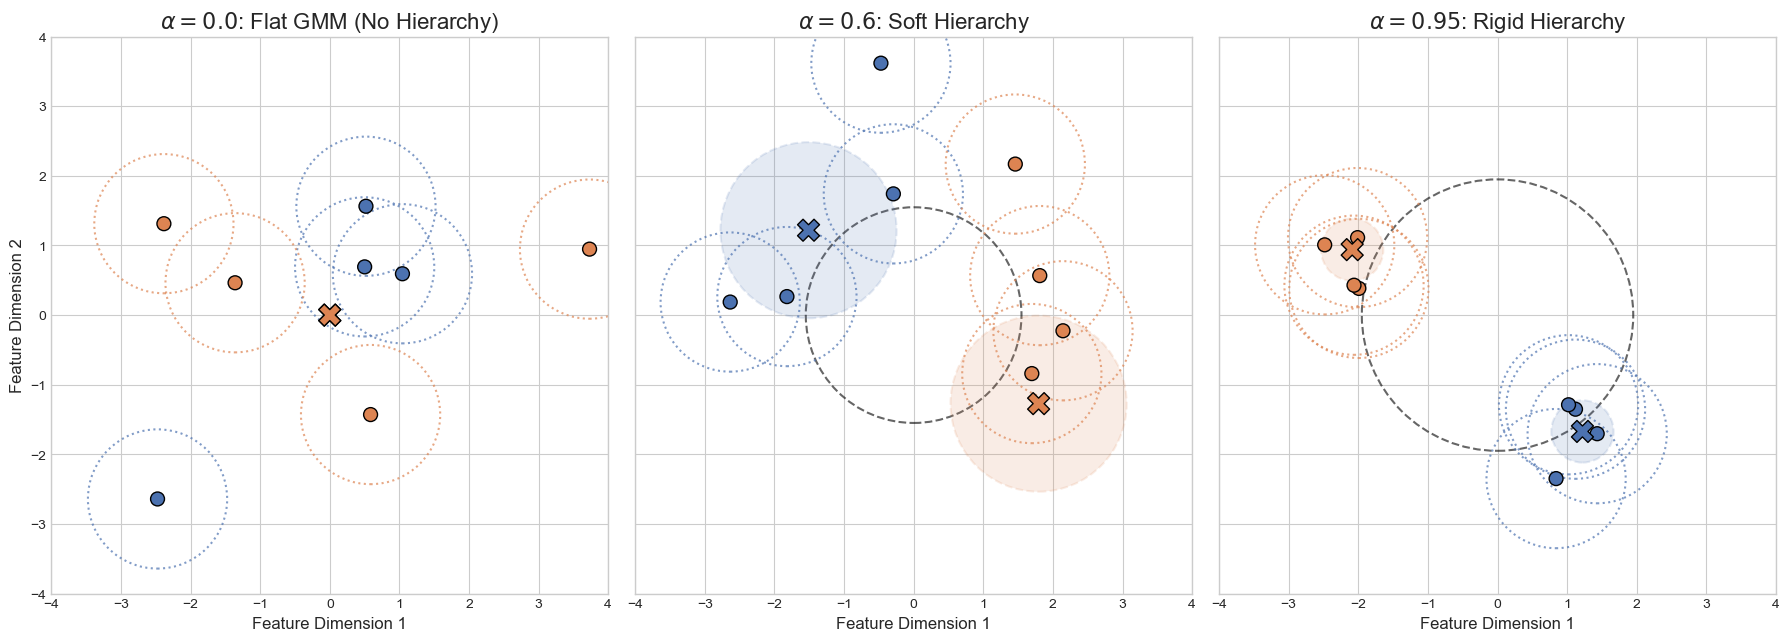

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle

# --- Parameters for the visualization ---
K = 8  # Total number of classes (sub-clusters)
G = 2  # Number of super-clusters
D = 2  # Feature dimension (we use 2D for plotting)
d_squared = 4.0  # Base distance (variance of centers)
node_noise_variance = 1.0 # The variance for the final node features

# Assign classes to super-groups and set colors
class_to_super = np.array([i // (K // G) for i in range(K)])
colors = sns.color_palette('deep', G)
class_colors = [colors[g] for g in class_to_super]

def generate_hierarchical_centroids(alpha, K, G, D, d_squared, class_to_super):
    """
    Generates class centroids based on the hierarchical model.
    Returns both class means and the super means used to create them.
    """
    tau_top_var = alpha * d_squared
    tau_class_var = (1 - alpha) * d_squared
    
    # Using a fixed seed here just for this specific visualization's consistency
    mu_top = np.random.multivariate_normal(
        mean=np.zeros(D), cov=np.identity(D) * tau_top_var, size=G)
    
    mu_class = np.zeros((K, D))
    for k in range(K):
        parent_super_mean = mu_top[class_to_super[k]]
        mu_class[k, :] = np.random.multivariate_normal(
            mean=parent_super_mean, cov=np.identity(D) * tau_class_var)
        
    return mu_class, mu_top

# --- Create the plot ---
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
alphas_to_plot = [0.0, 0.6, 0.95]
titles = [
    r'$\alpha = 0.0$: Flat GMM (No Hierarchy)',
    r'$\alpha = 0.6$: Soft Hierarchy',
    r'$\alpha = 0.95$: Rigid Hierarchy'
]

for i, alpha in enumerate(alphas_to_plot):
    ax = axes[i]
    
    centroids, mu_top = generate_hierarchical_centroids(
        alpha, K, G, D, d_squared, class_to_super
    )
    
    # Draw reference circle for super-group sampling
    tau_top_std = np.sqrt(alpha * d_squared)
    origin_circle = Circle((0, 0), tau_top_std, color='k', linestyle='--', fill=False, lw=1.5, alpha=0.6)
    ax.add_patch(origin_circle)

    # Draw reference circles for sub-group sampling
    if alpha > 0:
        tau_class_std = np.sqrt((1.0 - alpha) * d_squared)
        for g in range(G):
            super_mean_circle = Circle(mu_top[g], tau_class_std, color=colors[g], linestyle='--', 
                                       fill=True, lw=1.5, alpha=0.15)
            ax.add_patch(super_mean_circle)

    # --- ADDED: Draw circles of unit variance around each sub-cluster center ---
    node_noise_std = np.sqrt(node_noise_variance)
    for k in range(K):
        center = centroids[k]
        # Use a fine dotted line for this final level of variance
        node_noise_circle = Circle(center, node_noise_std, edgecolor=class_colors[k], 
                                   linestyle=':', fill=False, lw=1.5, alpha=0.7)
        ax.add_patch(node_noise_circle)

    # Plot the class centroids (dots) and super-group means (X's)
    ax.scatter(centroids[:, 0], centroids[:, 1], c=class_colors, s=100, alpha=1.0, edgecolors='k', zorder=10)
    ax.scatter(mu_top[:, 0], mu_top[:, 1], c=colors, s=250, marker='X', edgecolors='k', zorder=10)

    ax.set_title(titles[i], fontsize=16)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('Feature Dimension 1', fontsize=12)
    ax.set_ylabel('Feature Dimension 2' if i == 0 else '', fontsize=12)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)

# fig.suptitle('Visualisation of Class Centroid Geometry as Hierarchy Parameter $\\alpha$ Varies', fontsize=18, y=1.05)
plt.tight_layout()
plt.savefig('hierarchical_feature_space_full_variance.png', dpi=300, bbox_inches='tight')
plt.show()

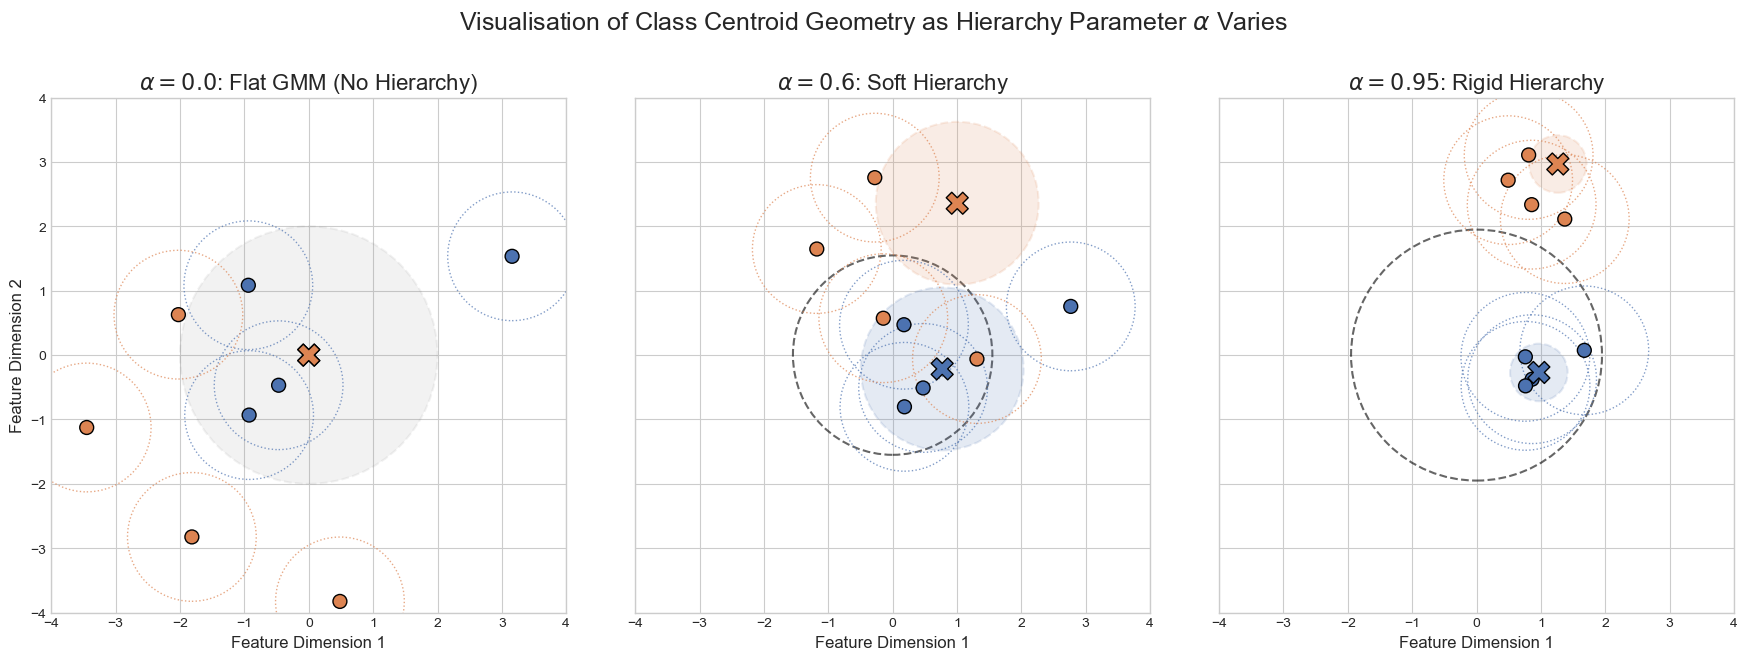

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle

# --- Parameters for the visualization ---
K = 8  # Total number of classes (sub-clusters)
G = 2  # Number of super-clusters
D = 2  # Feature dimension (we use 2D for plotting)
d_squared = 4.0  # Base distance (variance of centers)
node_noise_variance = 1.0 # The variance for the final node features

# Assign classes to super-groups and set colors
class_to_super = np.array([i // (K // G) for i in range(K)])
colors = sns.color_palette('deep', G)
class_colors = [colors[g] for g in class_to_super]

def generate_hierarchical_centroids(alpha, K, G, D, d_squared, class_to_super):
    """
    Generates class centroids based on the hierarchical model.
    Returns both class means and the super means used to create them.
    """
    tau_top_var = alpha * d_squared
    tau_class_var = (1 - alpha) * d_squared
    
    # Using a fixed seed for visualization consistency
    np.random.seed(42) 
    mu_top = np.random.multivariate_normal(
        mean=np.zeros(D), cov=np.identity(D) * tau_top_var, size=G)
    
    mu_class = np.zeros((K, D))
    for k in range(K):
        parent_super_mean = mu_top[class_to_super[k]]
        mu_class[k, :] = np.random.multivariate_normal(
            mean=parent_super_mean, cov=np.identity(D) * tau_class_var)
        
    return mu_class, mu_top

# --- Create the plot ---
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
alphas_to_plot = [0.0, 0.6, 0.95]
titles = [
    r'$\alpha = 0.0$: Flat GMM (No Hierarchy)',
    r'$\alpha = 0.6$: Soft Hierarchy',
    r'$\alpha = 0.95$: Rigid Hierarchy'
]

for i, alpha in enumerate(alphas_to_plot):
    ax = axes[i]
    
    centroids, mu_top = generate_hierarchical_centroids(
        alpha, K, G, D, d_squared, class_to_super
    )
    
    # --- CORRECTED LOGIC FOR PLOTTING REFERENCE CIRCLES ---
    if alpha == 0:
        # For the flat case, draw one circle at the origin representing the total variance
        # from which all sub-clusters are sampled.
        std_dev = np.sqrt(d_squared)
        reference_circle = Circle((0, 0), std_dev, color='gray', linestyle='--', 
                                  fill=True, lw=1.5, alpha=0.1)
        ax.add_patch(reference_circle)
    else:
        # For hierarchical cases, draw a circle for super-group sampling...
        tau_top_std = np.sqrt(alpha * d_squared)
        origin_circle = Circle((0, 0), tau_top_std, color='k', linestyle='--', 
                               fill=False, lw=1.5, alpha=0.6)
        ax.add_patch(origin_circle)
        
        # ...and also draw circles for the sub-group sampling around each super-mean.
        tau_class_std = np.sqrt((1.0 - alpha) * d_squared)
        for g in range(G):
            super_mean_circle = Circle(mu_top[g], tau_class_std, color=colors[g], 
                                       linestyle='--', fill=True, lw=1.5, alpha=0.15)
            ax.add_patch(super_mean_circle)

    # Draw circles of unit variance around each sub-cluster center
    node_noise_std = np.sqrt(node_noise_variance)
    for k in range(K):
        center = centroids[k]
        node_noise_circle = Circle(center, node_noise_std, edgecolor=class_colors[k], 
                                   linestyle=':', fill=False, lw=1.0, alpha=0.7)
        ax.add_patch(node_noise_circle)

    # Plot the class centroids (dots) and super-group means (X's)
    ax.scatter(centroids[:, 0], centroids[:, 1], c=class_colors, s=100, alpha=1.0, edgecolors='k', zorder=10)
    ax.scatter(mu_top[:, 0], mu_top[:, 1], c=colors, s=250, marker='X', edgecolors='k', zorder=10)

    ax.set_title(titles[i], fontsize=16)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('Feature Dimension 1', fontsize=12)
    ax.set_ylabel('Feature Dimension 2' if i == 0 else '', fontsize=12)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)

fig.suptitle('Visualisation of Class Centroid Geometry as Hierarchy Parameter $\\alpha$ Varies', fontsize=18, y=1.05)
plt.tight_layout()
plt.savefig('hierarchical_feature_space_final_corrected.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import sys
import os

# Get the path of the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
print(parent_dir)
# Get the path of the subdirectory containing your module
sbm_dir = os.path.join(parent_dir, 'graph_world/generators')
print(sbm_dir)
# Add the subdirectory to Python's path
if sbm_dir not in sys.path:
    sys.path.append(sbm_dir)


/Users/daniel/Documents/masters_ai/thesis/graphworld/src
/Users/daniel/Documents/masters_ai/thesis/graphworld/src/graph_world/generators


Generating Flat SBM graph...
Generating Hierarchical SBM graph...
Generating final plot...


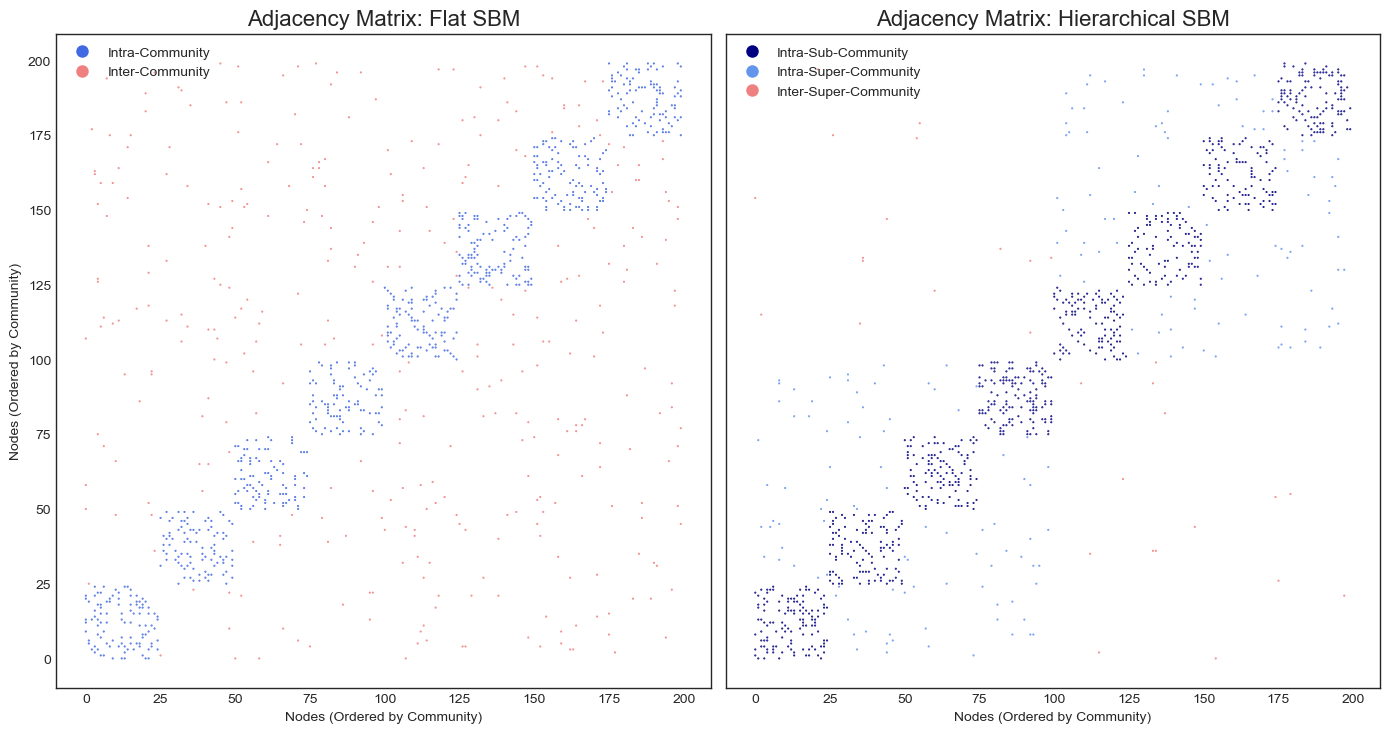

Generating networkx node-link diagrams...


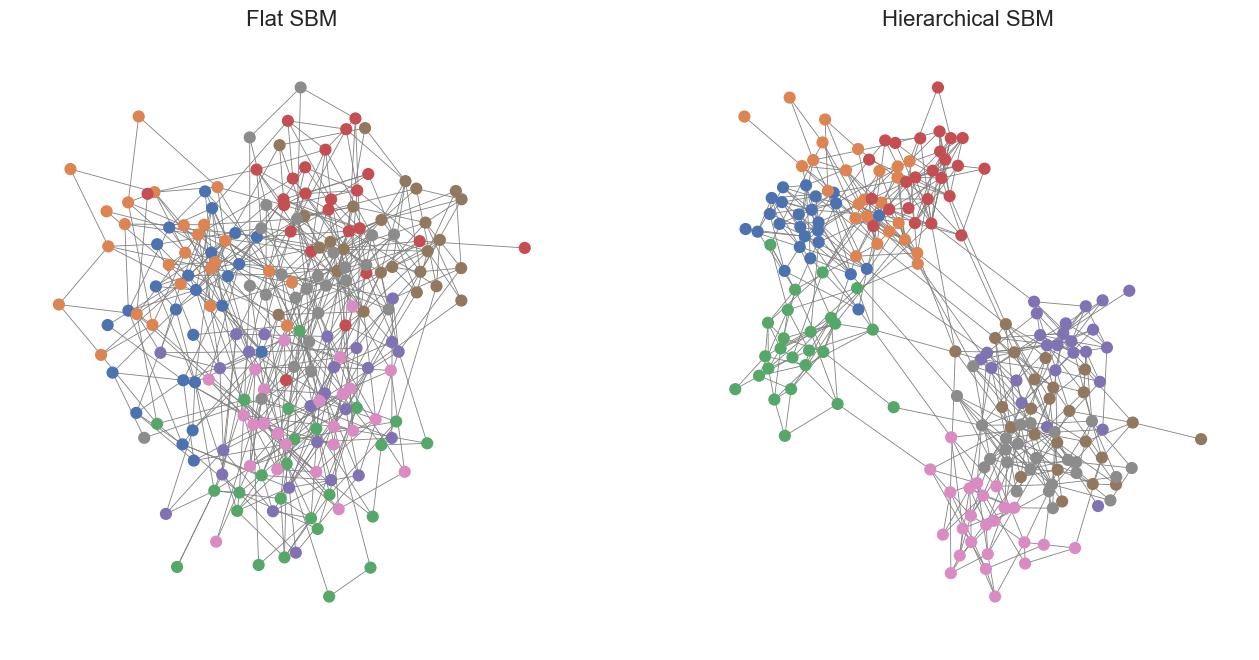

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
import networkx as nx

# Assuming your sbm_simulator.py file is in the same directory
import sbm_simulator as sbm

# --- 1. Define Common Parameters ---
N_VERTICES = 200  # A good size for this visualization
AVG_DEGREE = 12
NUM_CLUSTERS = 8 # 2 super-clusters of 4
P_TO_Q_RATIO = 15.0 # High ratio for very clear visual blocks


# --- 2. Generate the Flat SBM Graph ---
print("Generating Flat SBM graph...")
pi_flat = sbm.MakePi(NUM_CLUSTERS, community_size_slope=0.0)
prop_mat_flat = sbm.MakePropMat(NUM_CLUSTERS, P_TO_Q_RATIO)
num_edges_flat = N_VERTICES * AVG_DEGREE / 2
flat_sbm_data = sbm.StochasticBlockModel()
sbm.SimulateSbm(flat_sbm_data, N_VERTICES, num_edges_flat, pi_flat, prop_mat_flat)

# --- 3. Generate the Hierarchical SBM Graph ---
print("Generating Hierarchical SBM graph...")
p_intra_sub = 15.0
p_intra_super = 1.0
p_inter_super = 0.1
hsbm_data = sbm.StochasticBlockModel()
prop_mat_hierarchical = sbm.MakeHierarchicalPropMat(
    num_super_communities=2, subs_per_super=4,
    p_intra_sub=p_intra_sub, p_intra_super=p_intra_super, p_inter_super=p_inter_super
)
sbm.SimulateSbm(hsbm_data, N_VERTICES, num_edges_flat, pi_flat, prop_mat_hierarchical)

# --- 4. Prepare Data for Plotting ---

def get_flat_colored_edge_coords(sbm_data_object):
    """Returns coordinates and colors for a standard SBM plot (2 colors)."""
    memberships = sbm_data_object.graph_memberships
    perm_idx = np.argsort(memberships)
    pos_map = {original_id: new_pos for new_pos, original_id in enumerate(perm_idx)}

    coords = {'x': [], 'y': [], 'colors': []}
    colors_map = {'intra': 'royalblue', 'inter': 'lightcoral'}
    
    for edge in sbm_data_object.graph.edges():
        u, v = int(edge.source()), int(edge.target())
        coords['x'].extend([pos_map[u], pos_map[v]])
        coords['y'].extend([pos_map[v], pos_map[u]])
        color = colors_map['intra'] if memberships[u] == memberships[v] else colors_map['inter']
        coords['colors'].extend([color, color])
        
    return coords['x'], coords['y'], coords['colors']

def get_hierarchical_colored_edge_coords(sbm_data_object, subs_per_super):
    """Returns coordinates and colors for an hSBM plot (3 colors)."""
    memberships = sbm_data_object.graph_memberships
    perm_idx = np.argsort(memberships)
    pos_map = {original_id: new_pos for new_pos, original_id in enumerate(perm_idx)}

    coords = {'x': [], 'y': [], 'colors': []}
    colors_map = {'intra_sub': 'navy', 'intra_super': 'cornflowerblue', 'inter_super': 'lightcoral'}

    for edge in sbm_data_object.graph.edges():
        u, v = int(edge.source()), int(edge.target())
        coords['x'].extend([pos_map[u], pos_map[v]])
        coords['y'].extend([pos_map[v], pos_map[u]])
        
        sub_u, sub_v = memberships[u], memberships[v]
        super_u, super_v = sub_u // subs_per_super, sub_v // subs_per_super

        if sub_u == sub_v:
            color = colors_map['intra_sub']
        elif super_u == super_v:
            color = colors_map['intra_super']
        else:
            color = colors_map['inter_super']
        coords['colors'].extend([color, color])
            
    return coords['x'], coords['y'], coords['colors']

flat_coords = get_flat_colored_edge_coords(flat_sbm_data)
hierarchical_coords = get_hierarchical_colored_edge_coords(hsbm_data, 4)

# --- 5. Create the Visualization ---
print("Generating final plot...")
sns.set_style("white")
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

# Plot for Flat SBM
axes[0].scatter(flat_coords[0], flat_coords[1], c=flat_coords[2], s=1.0, marker='.', rasterized=True)
axes[0].set_title("Adjacency Matrix: Flat SBM", fontsize=16)
axes[0].set_xlabel("Nodes (Ordered by Community)")
axes[0].set_ylabel("Nodes (Ordered by Community)")
axes[0].set_aspect('equal', adjustable='box')
legend_flat = [
    Line2D([0], [0], marker='o', color='w', label='Intra-Community', markerfacecolor='royalblue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Inter-Community', markerfacecolor='lightcoral', markersize=10)
]
axes[0].legend(handles=legend_flat, loc='upper left')

# Plot for Hierarchical SBM
axes[1].scatter(hierarchical_coords[0], hierarchical_coords[1], c=hierarchical_coords[2], s=1.0, marker='.', rasterized=True)
axes[1].set_title("Adjacency Matrix: Hierarchical SBM", fontsize=16)
axes[1].set_xlabel("Nodes (Ordered by Community)")
axes[1].set_aspect('equal', adjustable='box')
legend_hierarchical = [
    Line2D([0], [0], marker='o', color='w', label='Intra-Sub-Community', markerfacecolor='navy', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Intra-Super-Community', markerfacecolor='cornflowerblue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Inter-Super-Community', markerfacecolor='lightcoral', markersize=10)
]
axes[1].legend(handles=legend_hierarchical, loc='upper left')


plt.tight_layout()
plt.savefig("sbm_vs_hsbm_adjacency_detailed.png") # Using PDF for vector graphics
plt.show()


# --- 3. Convert to Networkx and Prepare for Plotting ---
def convert_to_networkx(sbm_data_object):
    """Converts a graph-tool graph to a networkx graph."""
    g = nx.Graph()
    g.add_nodes_from(range(sbm_data_object.graph.num_vertices()))
    for edge in sbm_data_object.graph.edges():
        g.add_edge(int(edge.source()), int(edge.target()))
    return g

g_flat = convert_to_networkx(flat_sbm_data)
g_hierarchical = convert_to_networkx(hsbm_data)

# --- MODIFIED: Function to get ONLY the largest connected component ---
def get_largest_component_subgraph(graph, original_colors):
    """Finds the largest connected component and returns it as a subgraph with filtered colors."""
    # Find all connected components and select the largest one
    components = nx.connected_components(graph)
    largest_component = max(components, key=len)
    
    # Create the subgraph from the largest component
    subgraph = graph.subgraph(largest_component).copy()
    
    # Filter the colors to match the nodes in the subgraph
    # The subgraph preserves the original node indices, so we can access colors directly
    filtered_colors = [original_colors[i] for i in subgraph.nodes()]
            
    return subgraph, filtered_colors

palette = sns.color_palette("deep", NUM_CLUSTERS)
node_colors_flat_all = [palette[c] for c in flat_sbm_data.graph_memberships]
node_colors_hierarchical_all = [palette[c] for c in hsbm_data.graph_memberships]

g_flat_lcc, node_colors_flat = get_largest_component_subgraph(g_flat, node_colors_flat_all)
g_hierarchical_lcc, node_colors_hierarchical = get_largest_component_subgraph(g_hierarchical, node_colors_hierarchical_all)

# --- 4. Create the Visualization ---
print("Generating networkx node-link diagrams...")
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot Flat SBM
pos_flat = nx.spring_layout(g_flat_lcc, seed=42)
nx.draw(g_flat_lcc, pos=pos_flat, ax=axes[0], node_color=node_colors_flat, node_size=60, width=0.6, edge_color='gray')
axes[0].set_title("Flat SBM", fontsize=16)

# Plot Hierarchical SBM
pos_hierarchical = nx.spring_layout(g_hierarchical_lcc, seed=42)
nx.draw(g_hierarchical_lcc, pos=pos_hierarchical, ax=axes[1], node_color=node_colors_hierarchical, node_size=60, width=0.6, edge_color='gray')
axes[1].set_title("Hierarchical SBM", fontsize=16)

plt.savefig("sbm_vs_hsbm_nodelink_lcc.png", dpi=300)
plt.show()

In [ ]:
# now generated with signal noise variance of .25
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/gen_params_varied/rq2'
dfs = []
for i in range(1,5):
    df = df_gen(RESULTS_DIR + f'/{i}')
    dfs.append(df)
df5 = df_gen(RESULTS_DIR + '/5/5')
dfs.append(df5)
df = pd.concat(dfs)
df = df.reset_index(drop=True) 

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.nd

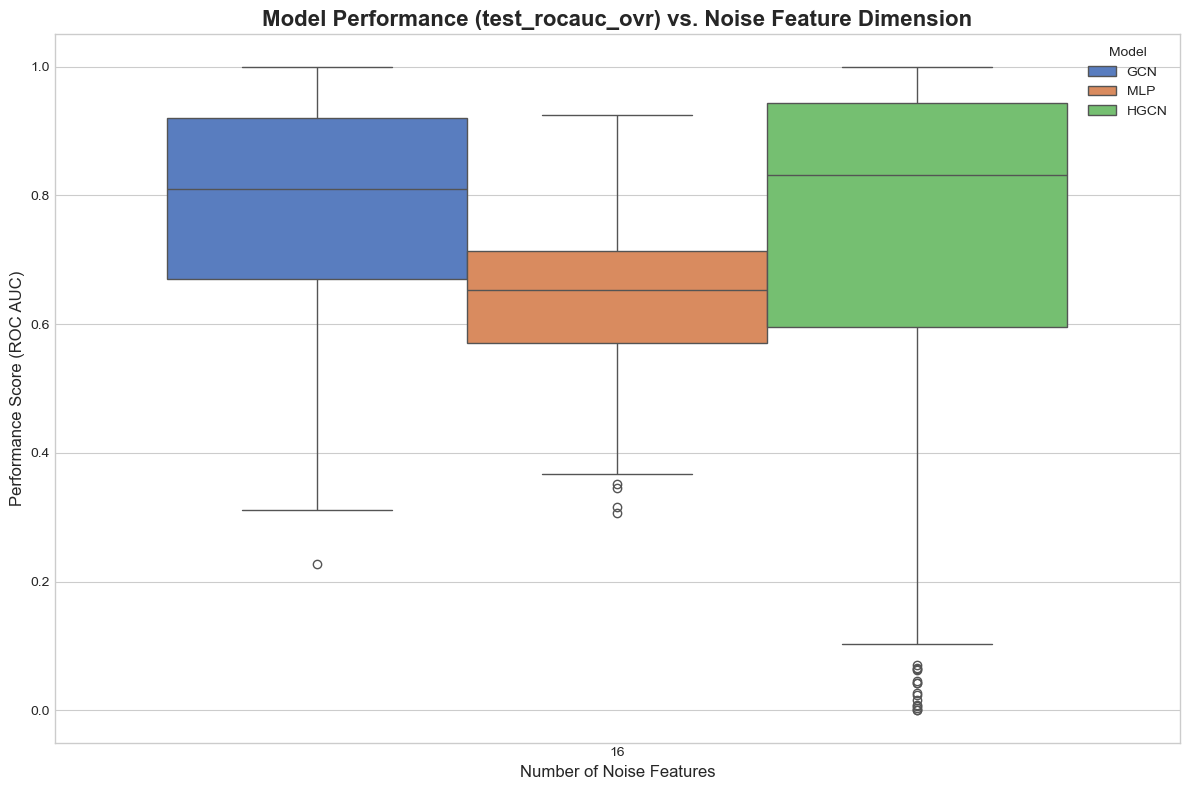

In [ ]:
plot_model_perf_vs_feature_noise_dim([df], models, metric, noise_feature_dims=[16])

In [ ]:
df[df['num_clusters'] == 8][graph_metrics_refined].describe()

,nvertex,avg_degree,degree_gini,p_to_q_ratio,num_clusters,community_size_simpsons,feature_center_distance,avg_cc,power_exponent,min_deg
count,295.000000,295.000000,295.000000,295.000000,295.0,295.000000,295.000000,295.000000,295.000000,295.000000
mean,2517.952542,14.949463,0.524298,8.675997,8.0,0.143725,0.962288,0.092158,1.640612,10.423729
std,860.391861,7.648235,0.101109,4.336788,0.0,0.009650,0.600605,0.074484,0.813178,5.204013
min,1026.000000,2.471256,0.337729,1.135035,8.0,0.125022,0.001966,0.001861,0.209948,2.000000
25%,1742.000000,7.986411,0.434085,5.142415,8.0,0.136240,0.435837,0.031511,0.950744,6.000000
50%,2532.000000,15.128873,0.520514,8.582148,8.0,0.145581,0.931724,0.073094,1.666601,11.000000
75%,3235.000000,21.004025,0.604974,12.537609,8.0,0.151797,1.514386,0.134337,2.390747,15.000000
max,4089.000000,31.693222,0.758348,15.955652,8.0,0.157240,1.993897,0.369299,2.995134,19.000000


In [ ]:
def smoothed_plot_perf_vs_metric(
    df: pd.DataFrame,
    models: list[str],
    perf_meas: str,
    metric: str,
    n_bins: int = 10,
    figsize: tuple[int, int] = (8, 5),
    cmap: str = 'tab10'
):
    """
    Plot smoothed binned performance vs. metric for multiple models,
    with shaded 95% confidence intervals around the mean.

    Parameters
    ----------
    df : DataFrame
        Must contain the column [metric] and, for each model in `models`,
        a performance column named model+perf_meas (e.g. 'GCN'+'accuracy' → 'GCNaccuracy').
    models : list of str
        Model-name prefixes.
    perf_meas : str
        Performance-measure suffix (e.g. 'f1_macro', 'accuracy').
    metric : str
        The continuous metric to bin (e.g. 'homophily_rate').
    n_bins : int, default=10
        Number of equal-width bins to split the metric into.
    figsize : (width, height)
        Figure size.
    cmap : str
        Matplotlib colormap for the model curves.
    """
    # 1. Create equal-width bins and label them by their center values
    bin_edges = np.linspace(df[metric].min(), df[metric].max(), n_bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)


    # 2. Initialize plot
    plt.figure(figsize=figsize)
    colors = plt.get_cmap(cmap)(np.linspace(0, 1, len(models)))

    # 3. For each model, compute mean and 95% CI in each bin and plot
    for model, color in zip(models, colors):
        col = f"{model}__{perf_meas}"
        if col not in df.columns:
            raise KeyError(f"Column '{col}' not found in DataFrame.")

        grp = df.groupby('_bin')[col]
        count = grp.count()                    # number of observations per bin
        mean = grp.mean()                      # mean performance per bin
        std  = grp.std(ddof=1)                 # sample standard deviation
        sem  = std / np.sqrt(count)            # standard error of the mean
        ci95 = 1.96 * sem                      

        # Only keep bins with data
        valid = count > 0
        x     = mean.index.astype(float)[valid]
        y     = mean[valid]
        lower = y - ci95[valid]
        upper = y + ci95[valid]

        # Plot mean line and shaded 95% CI
        plt.plot(x, y, label=model, color=color, linewidth=2)
        plt.fill_between(x, lower, upper, color=color, alpha=0.3)

    # 4. Final styling
    plt.xlabel(metric)
    plt.ylabel(perf_meas)
    plt.ylim(0,1)
    plt.title(f"{perf_meas} vs {metric} (binned, with 95% CI)")
    plt.legend(title="Model")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Clean up temporary column
    df.drop(columns=['_bin'], inplace=True)

In [ ]:
graph_metrics = ['nvertex', 'avg_degree', 'feature_center_distance',
       'p_to_q_ratio','num_clusters', 'cluster_size_slope', 'power_exponent', 'min_deg',
       'num_nodes', 'num_edges', 'edge_density',
       'degree_gini', 'coreness_eq_1',
       'coreness_geq_2', 'coreness_geq_5', 'coreness_geq_10', 'coreness_gini',
       'avg_cc', 'transitivity', 'num_triangles', 'cc_size',
       'power_law_estimate', 'edge_homogeneity',
       'avg_in_feature_angular_distance', 'avg_out_feature_angular_distance',
       'feature_angular_snr', 'pareto_exponent', 'avg_degree_est',
       'community_size_simpsons', 'p_to_q_ratio_est', 'p_to_q_ratio__est_dc']

graph_metrics_refined = ['nvertex', 'avg_degree', 'degree_gini', 'p_to_q_ratio',
              'community_size_simpsons', 'feature_center_distance',
                 'avg_cc', 'power_exponent', 'min_deg']

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version 

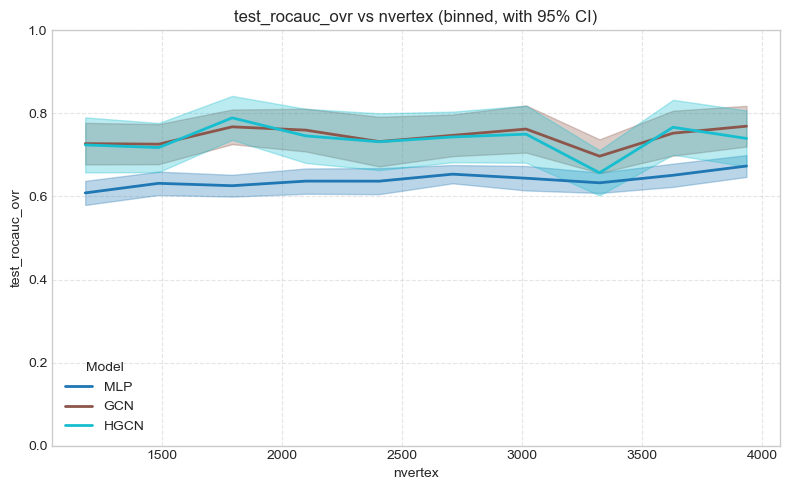

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

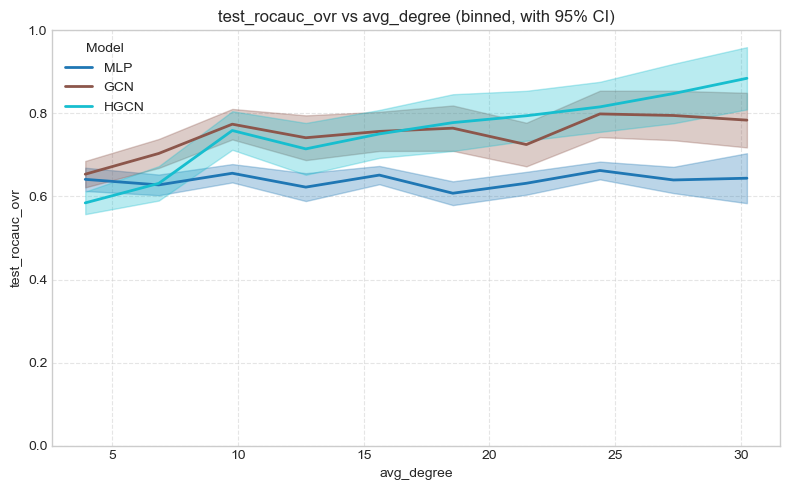

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

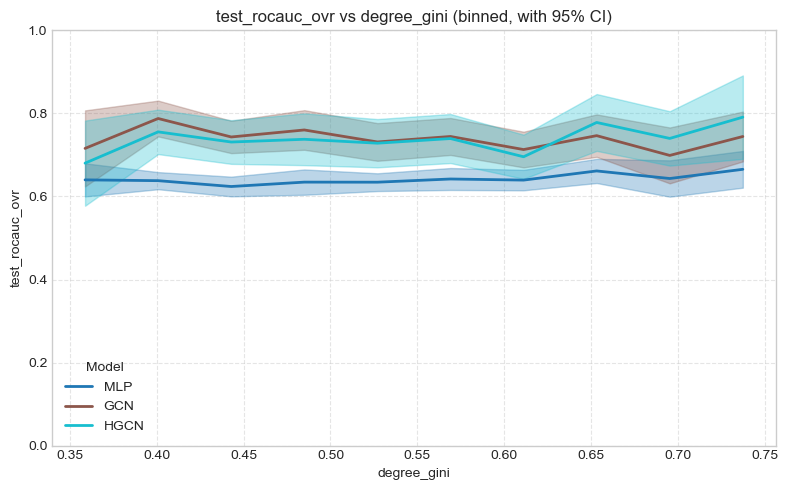

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

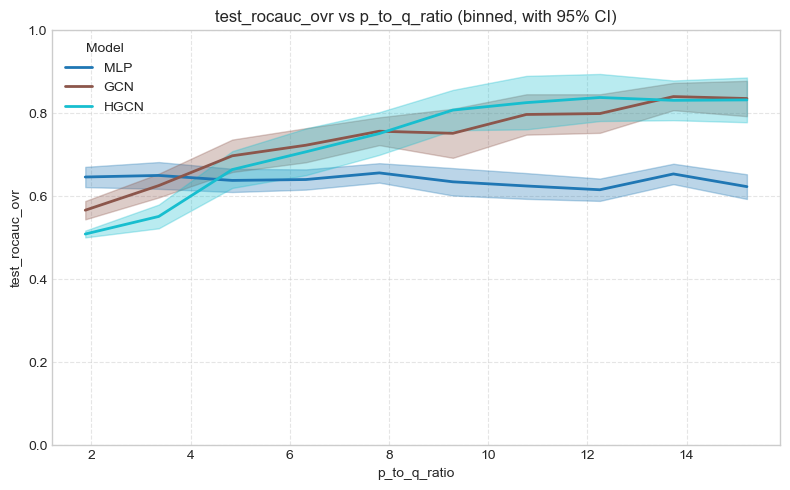

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

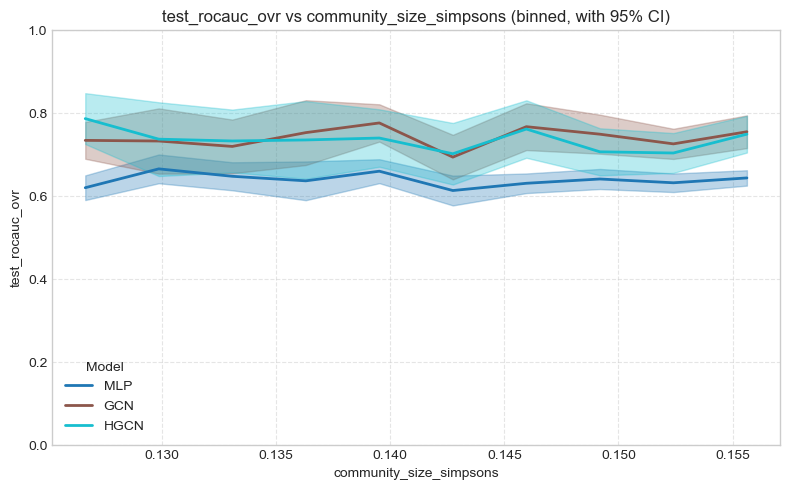

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

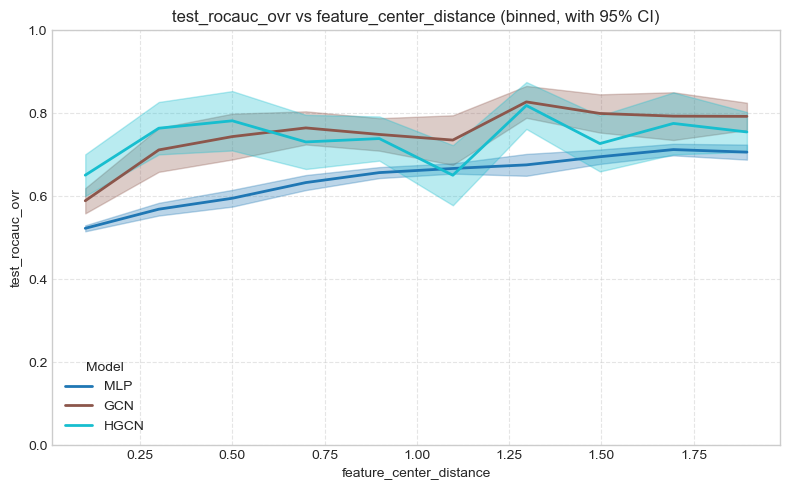

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

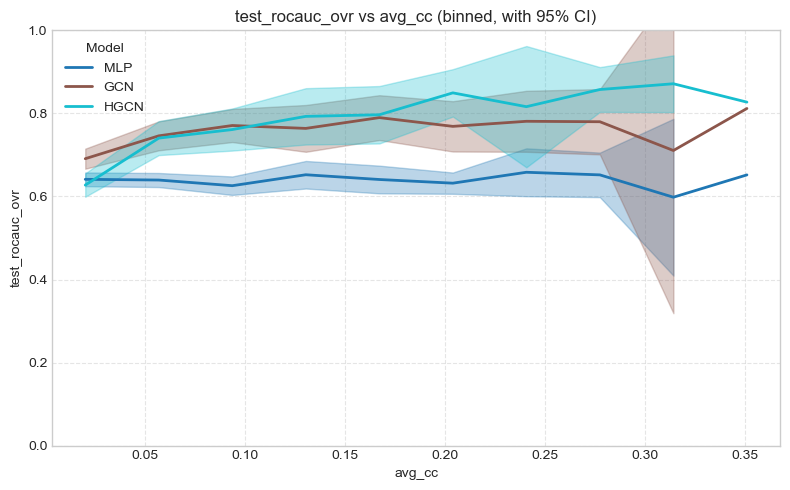

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

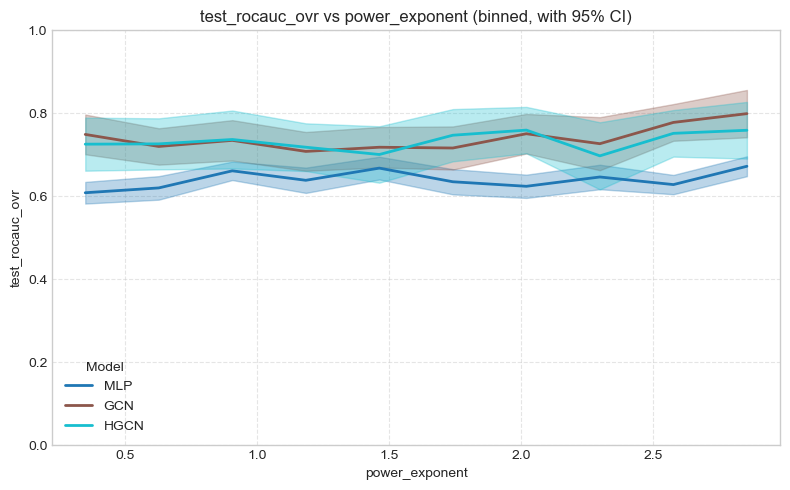

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

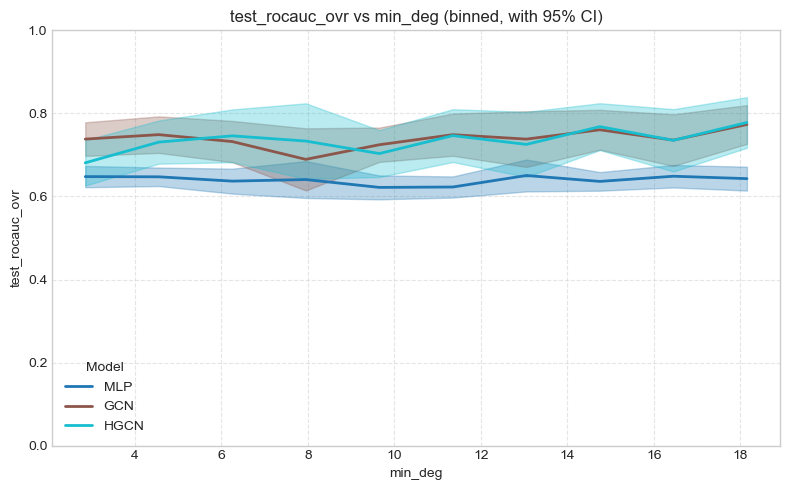

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)


In [ ]:
for m in graph_metrics_refined:
    smoothed_plot_perf_vs_metric(df[df['num_clusters'] == 8], models = ['MLP', 'GCN', 'HGCN'], perf_meas= 'test_rocauc_ovr', metric = m)

## FLAT FEAT FLAT COMMUNITIES

In [ ]:
## fixed parameter generation 
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/fixed_gen_params/flat_graph_flat_feat'
df1 = df_gen(RESULTS_DIR + '/1')
df2 = df_gen(RESULTS_DIR + '/2')
df = pd.concat([df1,df2])
df = df.reset_index(drop=True)
df

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,nvertex,avg_degree,feature_center_distance,feature_dim,edge_center_distance,edge_feature_dim,p_to_q_ratio,num_clusters,cluster_size_slope,power_exponent,...,HGCN__model_c,HGCN__model_dropout,HGCN__model_hidden_channels,HGCN__model_in_channels,HGCN__model_lr,HGCN__model_num_layers,HGCN__model_weight_decay,HGCN__model_out_channels,HGCN__train_epochs,HGCN__train_patience
0,2000,9.358961,0.8,16,1.0,1,3.0,8,0.0,2.5,...,0.5,0.2,32,16,0.0020,1,0.0005,8,200,20
1,2000,9.684690,0.8,16,1.0,1,3.0,8,0.0,2.5,...,0.5,0.4,32,16,0.0005,2,0.0005,8,200,20
2,2000,8.924180,0.8,16,1.0,1,3.0,8,0.0,2.5,...,1.0,0.4,8,16,0.0005,2,0.0000,8,200,20
3,2000,9.455465,0.8,16,1.0,1,3.0,8,0.0,2.5,...,0.5,0.0,16,16,0.0010,2,0.0010,8,200,20
4,2000,9.454821,0.8,16,1.0,1,3.0,8,0.0,2.5,...,1.0,0.2,16,16,0.0020,2,0.0005,8,200,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2000,9.812406,0.8,16,1.0,1,3.0,8,0.0,2.5,...,1.0,0.2,16,16,0.0020,2,0.0010,8,200,20
496,2000,9.496222,0.8,16,1.0,1,3.0,8,0.0,2.5,...,NaN,0.2,32,16,0.0005,2,0.0001,8,200,20
497,2000,8.950485,0.8,16,1.0,1,3.0,8,0.0,2.5,...,2.0,0.0,32,16,0.0005,2,0.0001,8,200,20
498,2000,9.780684,0.8,16,1.0,1,3.0,8,0.0,2.5,...,1.0,0.0,8,16,0.0020,2,0.0001,8,200,20


In [ ]:
df[['edge_homogeneity', 'avg_degree']].describe()

,edge_homogeneity,avg_degree
count,500.000000,500.000000
mean,0.287285,9.453031
std,0.005084,0.233322
min,0.270983,8.486570
25%,0.283867,9.323551
50%,0.287625,9.478390
75%,0.290507,9.618871
max,0.304894,10.019105


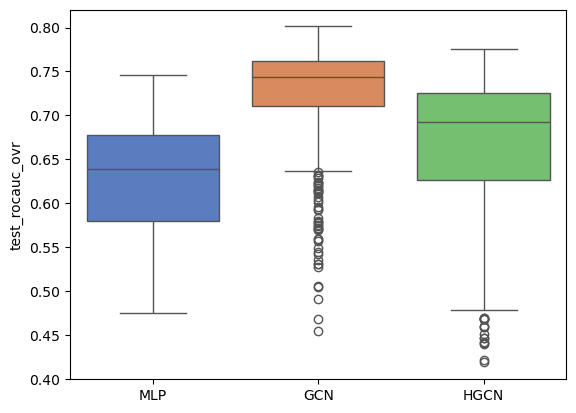

In [23]:
def boxplot_three_models(df, metric):
    models = ['MLP', 'GCN', 'HGCN']
    df_temp = df[[f'{model}__{metric}' for model in models]]
    df_temp = df_temp.rename(columns = {f'{model}__{metric}':model for model in models})
    sns.boxplot(df_temp,
                palette='muted'
                )
    plt.ylabel(metric)
    plt.show()

boxplot_three_models(df, 'test_rocauc_ovr')

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


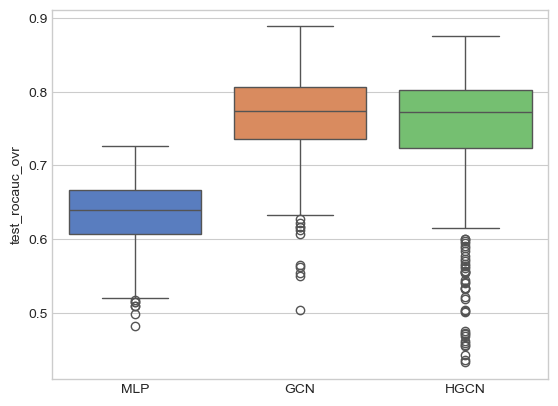

In [ ]:
## fixed parameter generation 
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2'
df1 = df_gen(RESULTS_DIR + '/3')
df2 = df_gen(RESULTS_DIR + '/4') 
df = pd.concat([df1, df2])
df = df.reset_index(drop=True)
boxplot_three_models(df, 'test_rocauc_ovr')

In [ ]:
df[[f'{model}__{metric}' for model in models]].describe()

,GCN__test_rocauc_ovr,MLP__test_rocauc_ovr,HGCN__test_rocauc_ovr
count,500.000000,500.000000,500.000000
mean,0.765740,0.633354,0.748231
std,0.056239,0.046505,0.082270
min,0.503474,0.481587,0.432278
25%,0.735904,0.607398,0.724005
50%,0.773936,0.639528,0.772578
75%,0.806162,0.667155,0.803048
max,0.889261,0.726036,0.876643


In [ ]:
df[['edge_homogeneity', 'avg_degree']].describe()

,edge_homogeneity,avg_degree
count,500.000000,500.000000
mean,0.473136,9.233290
std,0.007281,0.276852
min,0.445229,8.280374
25%,0.468246,9.076341
50%,0.473251,9.267764
75%,0.478456,9.447711
max,0.496204,9.795156


# Calibration

In [38]:
# flat features flat graph 
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/both_flat/1'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree', 'feature_center_distance', 'noise_var']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree,feature_center_distance,noise_var
count,100.000000,100.000000,100.0,1.000000e+02
mean,0.472717,9.245281,1.5,1.000000e-01
std,0.006918,0.226881,0.0,2.789540e-17
min,0.452462,8.537988,1.5,1.000000e-01
25%,0.468583,9.152958,1.5,1.000000e-01
50%,0.471533,9.259265,1.5,1.000000e-01
75%,0.477542,9.397030,1.5,1.000000e-01
max,0.490177,9.633434,1.5,1.000000e-01


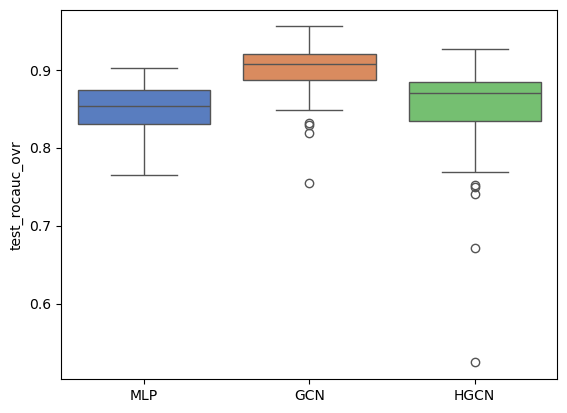

In [40]:
boxplot_three_models(df, metric = 'test_rocauc_ovr')

In [41]:
# flat features flat graph 
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/both_flat/calib'
df2 = df_gen(RESULTS_DIR + '/2')
df3 = df_gen(RESULTS_DIR + '/3')
df = pd.concat([df2,df3])
df = df.reset_index(drop=True)
df[['edge_homogeneity', 'avg_degree', 'feature_center_distance', 'noise_var']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_93259/465497905.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat(dfs)


,edge_homogeneity,avg_degree,feature_center_distance,noise_var
count,100.000000,100.000000,100.0,1.000000e+02
mean,0.473092,9.255105,1.0,1.000000e-01
std,0.006937,0.241582,0.0,2.789540e-17
min,0.453264,8.627931,1.0,1.000000e-01
25%,0.468773,9.130026,1.0,1.000000e-01
50%,0.473498,9.305337,1.0,1.000000e-01
75%,0.477848,9.433608,1.0,1.000000e-01
max,0.489742,9.646643,1.0,1.000000e-01


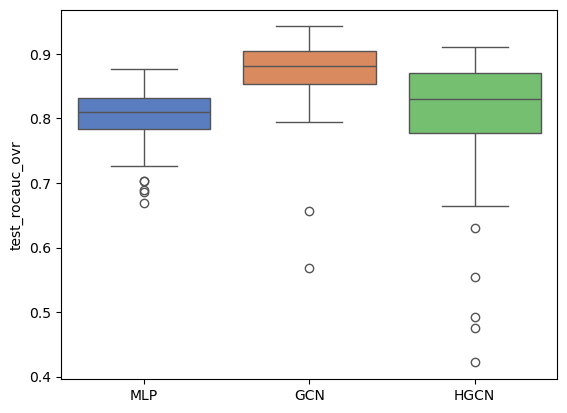

In [42]:
boxplot_three_models(df, metric = 'test_rocauc_ovr')

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
       edge_homogeneity  avg_degree  feature_center_distance     noise_var
count         50.000000   50.000000             5.000000e+01  5.000000e+01
mean           0.474007    9.272626             6.000000e-01  1.000000e-01
std            0.007118    0.239396             1.121495e-16  2.803737e-17
min            0.457492    8.428424             6.000000e-01  1.000000e-01
25%            0.470571    9.190778             6.000000e-01  1.000000e-01
50%            0.473900    9.324564             6.000000e-01  1.000000e-01
75%            0.478184    9.445633             6.000000e-01  1.000000e-01
max            0.490498    9.594554             6.000000e-01  1.000000e-01


/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_93259/465497905.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat(dfs)


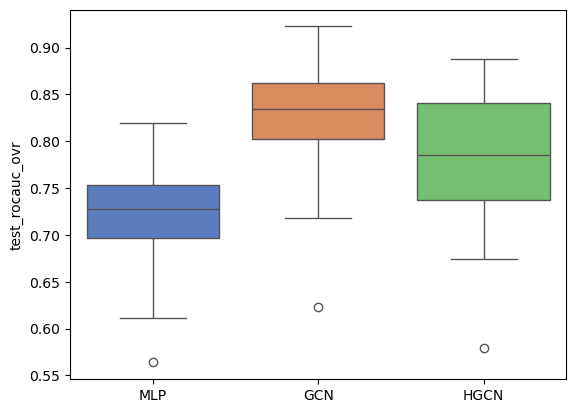

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
       edge_homogeneity  avg_degree  feature_center_distance     noise_var
count         50.000000   50.000000             5.000000e+01  5.000000e+01
mean           0.471723    9.164224             7.000000e-01  1.000000e-01
std            0.006464    0.253443             2.242989e-16  2.803737e-17
min            0.456197    8.557040             7.000000e-01  1.000000e-01
25%            0.467812    8.995406             7.000000e-01  1.000000e-01
50%            0.472115    9.151107             7.000000e-01  1.000000e-01
75%            0.476150    9.368606             7.000000e-01  1.000000e-01
max            0.482549    9.698588             7.000000e-01  1.000000e-01


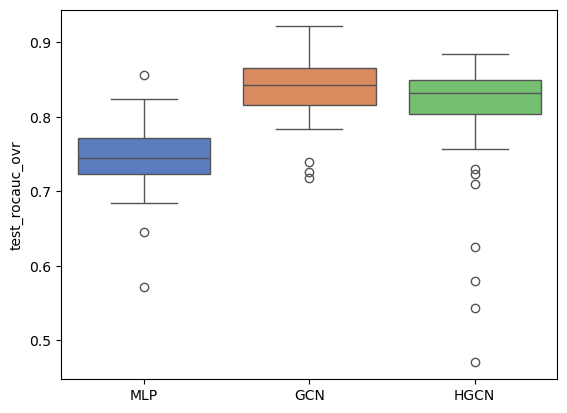

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
       edge_homogeneity  avg_degree  feature_center_distance     noise_var
count         50.000000   50.000000             5.000000e+01  5.000000e+01
mean           0.471964    9.231044             8.000000e-01  1.000000e-01
std            0.007867    0.224857             2.242989e-16  2.803737e-17
min            0.453347    8.888548             8.000000e-01  1.000000e-01
25%            0.466530    9.056471             8.000000e-01  1.000000e-01
50%            0.471928    9.189226             8.000000e-01  1.000000e-01
75%            0.475810    9.377078             8.000000e-01  1.000000e-01
max            0.490877    9.744209             8.000000e-01  1.000000e-01


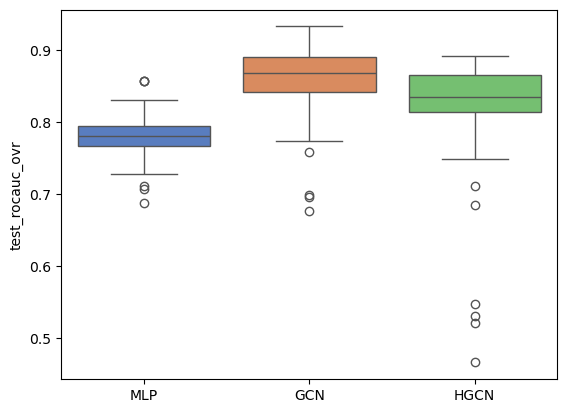

In [43]:
# flat features flat graph 
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/both_flat/calib'
for i in range(4,7):
    df = df_gen(RESULTS_DIR + f'/{i}')
    print(df[['edge_homogeneity', 'avg_degree', 'feature_center_distance', 'noise_var']].describe())
    boxplot_three_models(df, metric = 'test_rocauc_ovr')

## HSBM

In [ ]:
# here: p_inter_super=0.5, p_intra_sub=12.0, p_intra_super=4.0
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hsbm/1'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree
count,20.000000,20.000000
mean,0.440996,9.135278
std,0.004960,0.299276
min,0.434787,8.400208
25%,0.436348,8.984934
50%,0.439380,9.203453
75%,0.445861,9.339070
max,0.448469,9.529471


In [ ]:
# here: p_inter_super=0.5, p_intra_sub=20.0, p_intra_super=4.0
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hsbm/2'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree
count,20.000000,20.000000
mean,0.559314,9.003521
std,0.005982,0.312268
min,0.550571,8.365514
25%,0.554583,8.778414
50%,0.557477,9.062644
75%,0.563620,9.251074
max,0.572632,9.517939


In [ ]:
# here: p_inter_super=0.5, p_intra_sub=14.0, p_intra_super=4.0
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hsbm/3'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree
count,100.000000,100.000000
mean,0.478203,9.193496
std,0.007260,0.302139
min,0.455488,8.310133
25%,0.474111,9.040622
50%,0.479090,9.228354
75%,0.482607,9.408475
max,0.502968,9.793451


## Hierarchical feats 

In [7]:
# here: feature_center_distance = 0.8, alpha = .9
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/1'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree', 'MLP__test_rocauc_ovr']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree,MLP__test_rocauc_ovr
count,50.000000,50.000000,50.000000
mean,0.473533,9.214894,0.588060
std,0.007455,0.236733,0.052759
min,0.458777,8.679918,0.489968
25%,0.468337,9.034892,0.553311
50%,0.474270,9.257839,0.589041
75%,0.478874,9.380688,0.626191
max,0.488817,9.633618,0.697678


In [8]:
# here: feature_center_distance = 1.0, alpha = .9
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/2'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree', 'MLP__test_rocauc_ovr']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree,MLP__test_rocauc_ovr
count,50.000000,50.000000,50.000000
mean,0.473238,9.248688,0.597785
std,0.007399,0.247609,0.061150
min,0.457095,8.517683,0.473615
25%,0.469663,9.100571,0.553186
50%,0.472047,9.295228,0.595900
75%,0.478636,9.452081,0.634898
max,0.490504,9.592165,0.749326


In [9]:
# here: feature_center_distance = 1.3, alpha = .9
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/3'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree', 'MLP__test_rocauc_ovr']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree,MLP__test_rocauc_ovr
count,50.000000,50.000000,50.000000
mean,0.474005,9.250459,0.605205
std,0.007201,0.199654,0.054013
min,0.461718,8.671843,0.473761
25%,0.468879,9.124826,0.571825
50%,0.473409,9.258344,0.609860
75%,0.479412,9.357162,0.637078
max,0.488362,9.719352,0.718675


In [ ]:
# here: feature_center_distance = 1.5, alpha = .8
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/5'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree', 'MLP__test_rocauc_ovr']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree,MLP__test_rocauc_ovr
count,50.000000,50.000000,50.000000
mean,0.474480,9.304677,0.621334
std,0.007283,0.231965,0.055827
min,0.459307,8.765521,0.505834
25%,0.470299,9.147691,0.577781
50%,0.474672,9.308175,0.620967
75%,0.479960,9.486485,0.662855
max,0.492032,9.798583,0.738505


In [ ]:
# here: feature_center_distance = 2.0, alpha = .9
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/4'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree', 'MLP__test_rocauc_ovr']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree,MLP__test_rocauc_ovr
count,50.000000,50.000000,50.000000
mean,0.474649,9.329298,0.635184
std,0.007022,0.248565,0.051442
min,0.460339,8.405738,0.516828
25%,0.468860,9.204643,0.602997
50%,0.473550,9.380156,0.642835
75%,0.480999,9.464310,0.675947
max,0.487675,9.732529,0.714325


In [19]:
# here: feature_center_distance = 1.5, alpha = .8
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/6'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree', 'MLP__test_rocauc_ovr', 'feature_center_distance', 'alpha']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree,MLP__test_rocauc_ovr,feature_center_distance,alpha
count,50.000000,50.000000,50.000000,50.0,5.000000e+01
mean,0.471308,9.197066,0.616655,1.5,8.000000e-01
std,0.007990,0.267075,0.063678,0.0,2.242989e-16
min,0.449860,8.362615,0.508544,1.5,8.000000e-01
25%,0.466178,9.015595,0.563052,1.5,8.000000e-01
50%,0.470851,9.203723,0.628648,1.5,8.000000e-01
75%,0.477682,9.418413,0.669122,1.5,8.000000e-01
max,0.484512,9.716448,0.737968,1.5,8.000000e-01


In [20]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/7'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree', 'MLP__test_rocauc_ovr', 'feature_center_distance', 'alpha']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree,MLP__test_rocauc_ovr,feature_center_distance,alpha
count,50.000000,50.000000,50.000000,50.0,50.0
mean,0.471081,9.162553,0.632991,1.7,0.9
std,0.007642,0.278014,0.060149,0.0,0.0
min,0.446827,8.342174,0.498630,1.7,0.9
25%,0.467290,9.068135,0.579778,1.7,0.9
50%,0.472221,9.185762,0.647499,1.7,0.9
75%,0.474758,9.338381,0.676678,1.7,0.9
max,0.490038,9.686710,0.733808,1.7,0.9


## Both

In [21]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/both_hier/5'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree', 'MLP__test_rocauc_ovr', 'feature_center_distance', 'alpha']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree,MLP__test_rocauc_ovr,feature_center_distance,alpha
count,60.000000,60.000000,60.000000,60.0,60.0
mean,0.472213,9.215430,0.641591,1.7,0.9
std,0.007185,0.276783,0.065016,0.0,0.0
min,0.456900,8.656090,0.502705,1.7,0.9
25%,0.467648,9.023134,0.597761,1.7,0.9
50%,0.472237,9.237161,0.654686,1.7,0.9
75%,0.476375,9.444588,0.692229,1.7,0.9
max,0.493326,9.667338,0.747605,1.7,0.9


In [30]:
models = ['MLP', 'GCN', 'HGCN']
metric = 'test_rocauc_ovr'

# Main runs

## Hier community main exp

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


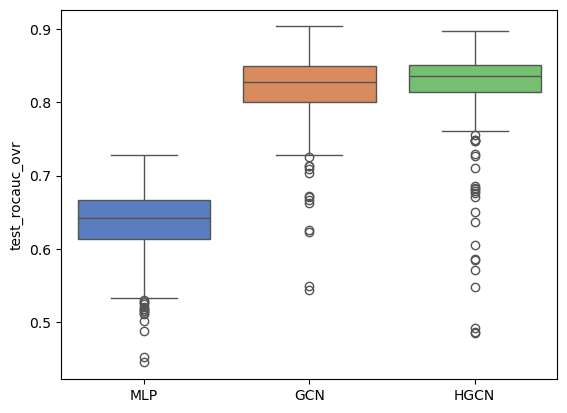

,MLP__test_rocauc_ovr,GCN__test_rocauc_ovr,HGCN__test_rocauc_ovr
count,500.000000,500.000000,500.000000
mean,0.635937,0.821994,0.824954
std,0.045248,0.042181,0.049407
min,0.445452,0.544159,0.485790
25%,0.613336,0.800876,0.813785
50%,0.642143,0.828111,0.835623
75%,0.666665,0.849195,0.851383
max,0.728818,0.903292,0.897542


In [31]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hsbm/run'
dfs = []
for i in range(1,3):
    df = df_gen(RESULTS_DIR + f'/{i}')
    dfs.append(df)
df = pd.concat(dfs)
df = df.reset_index(drop=True)
boxplot_three_models(df, 'test_rocauc_ovr')
df[[f'{model}__{metric}' for model in models]].describe()

## Hier feat main exp

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.nd

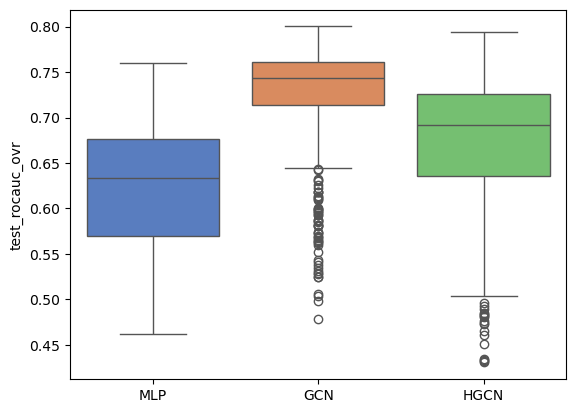

,MLP__test_rocauc_ovr,GCN__test_rocauc_ovr,HGCN__test_rocauc_ovr
count,500.000000,500.000000,500.000000
mean,0.623843,0.723127,0.670946
std,0.065850,0.061206,0.074936
min,0.461837,0.478409,0.430471
25%,0.569589,0.714146,0.635722
50%,0.633285,0.743444,0.691662
75%,0.676345,0.760834,0.726113
max,0.759943,0.800151,0.793561


In [32]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/main_run'
dfs = []
for i in range(1,6):
    df = df_gen(RESULTS_DIR+f'/{i}')
    dfs.append(df)
df = pd.concat(dfs)
df = df.reset_index(drop=True)
boxplot_three_models(df, 'test_rocauc_ovr')
df[[f'{model}__{metric}' for model in models]].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


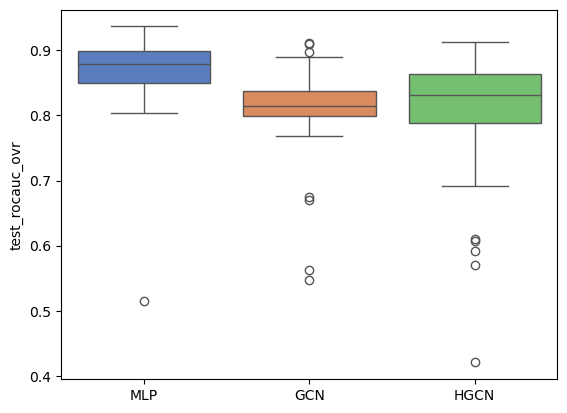

,MLP__test_rocauc_ovr,GCN__test_rocauc_ovr,HGCN__test_rocauc_ovr
count,100.000000,100.000000,100.000000
mean,0.872901,0.813217,0.814673
std,0.047607,0.052223,0.079081
min,0.514680,0.546690,0.420526
25%,0.849621,0.799066,0.788820
50%,0.878865,0.813996,0.831734
75%,0.898865,0.837432,0.863946
max,0.936694,0.910721,0.912187


In [36]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/no_noise/no_noise/1'
df = df_gen(RESULTS_DIR)
boxplot_three_models(df, 'test_rocauc_ovr')
df[[f'{model}__{metric}' for model in models]].describe()

## Both hier main exp

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


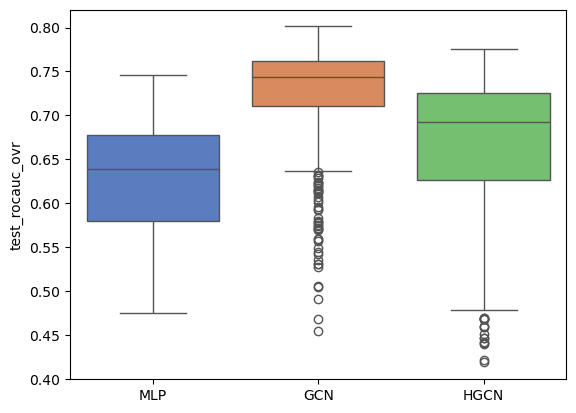

In [24]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/both_hier/main_run'
dfs = []
for i in range(1,3):
    df = df_gen(RESULTS_DIR+f'/{i}')
    dfs.append(df)
df = pd.concat(dfs)
df = df.reset_index(drop=True)
boxplot_three_models(df, 'test_rocauc_ovr')